In [1]:
from statsmodels.tsa.stattools import adfuller, kpss
import scipy

def ADF_test(x):
    # p-value小于0.05则证明序列平稳
    result = adfuller(x, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')


def KPSS_test(x):
    # p-value大于0.05则证明序列平稳
    result = kpss(x, regression='c')
    print('\nKPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[3].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
        
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_ACF_and_PCAF(data, lags=10):
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    plot_acf(data, lags=lags, ax=axes[0])
    plot_pacf(data, lags=lags, ax=axes[1])
    

def pre_handle(timeseries):
    d_value = 0
    result = adfuller(timeseries)
    if result[1] >= 0.05:
        result_diff1 = adfuller(timeseries.diff().dropna())
        d_value = 1
        if result_diff1[1] >= 0.05 and len(timeseries.diff().diff().dropna())>3:
            d_value = 2
            
            result_diff2 = adfuller(timeseries.diff().diff().dropna())
            timeseries = timeseries.diff().diff().dropna()
        else:
            timeseries = timeseries.diff().dropna()
            d_value = 1
    result = adfuller(timeseries)   
    return timeseries, d_value

def split_data(timeseries, split_percent):
    # Create Training and Test
    data_list = timeseries
    train_percent = split_percent/100
    split_index = int(train_percent * len(data_list))
    train = data_list[:split_index]
    test = data_list[split_index:]
    return train, test

from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    return({'mape':mape})


In [2]:
# PCA
import numpy as np
from sklearn.decomposition import PCA
def get_major_features(array):
    # 生成等长的单位向量
    base_array = np.ones(len(array))
    compose_array = np.array([array, base_array])
    pca = PCA(n_components=1)
    X = np.array(compose_array)
    pca.fit(X)
    X_transform = pca.transform(X)
    return X_transform



def get_CDF_plot(creteria_dict: dict, X_label: str, font_size: int = 14):
    for split_time, data in creteria_dict.items():
        print(split_time, pd.Series(data).mean())
        plt.rc('font',family='Times New Roman')
        ecdf = sm.distributions.ECDF(data)
        #等差数列，用于绘制X轴数据
        x = np.linspace(min(data), max(data))
        # x轴数据上值对应的累计密度概率
        y = ecdf(x)
        #绘制阶梯图
        plt.plot(x, y, label=f"{split_time} historical traffic matrixes")
        plt.xticks([0.05, 0.2, 0.5, 0.8, 1], fontsize=font_size)
        plt.yticks([0, 0.5, 0.8, 0.9, 1], fontsize=font_size)
        plt.xlabel(X_label, fontsize=font_size)
        plt.ylabel("CDF", fontsize=font_size)
        
    return plt


def get_mean_values_per_placement(traffic_groupby_pair: dict, ip_pairs: list, split_time: int, matrix_per_placement: np.matrix):
    mean_values_per_placement = {}
    for pair in ip_pairs:
        traffic_data = traffic_groupby_pair.get_group(pair).reset_index().traffic
        current_end = 0
        mean_values_per_placement[pair] = []
        for i in range(1, split_time+1):
            previous_end = current_end
            current_end = previous_end + int(len(traffic_data)/split_time)
            traffic_per_placement = traffic_data[previous_end:current_end]
            x, y = pair
            array_expressed_value = traffic_per_placement.sum()
            matrix_per_placement[i][x][y] = array_expressed_value
            mean_values_per_placement[pair].append(array_expressed_value)
            
    std_list = pd.Series([pd.Series(mean_values_per_placement[pair]).std() for pair in ip_pairs])
    return mean_values_per_placement, matrix_per_placement


In [3]:
import pandas as pd
import numpy as np
import utils
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings

warnings.filterwarnings("ignore")

traffic_series = pd.read_csv("./traffic-composite_placements.csv")
traffic_groupby_pair = traffic_series.groupby(['ip_src','ip_dst'])
ip_pairs = traffic_groupby_pair.groups.keys()


# 将每条流的序列平均分为split_time组
split_times = [5, 10, 30, 60, 100]


accurancy_records_per_split = {}
traffic_matries_records = {}

for split_time in split_times:
    # 每次放置对应的流量矩阵
    matrix_per_placement = {placement_time: np.zeros((len(ip_pairs)+1, len(ip_pairs)+1), dtype=float) 
                        for placement_time in range(1, split_time+1)}
    
    print(f"split: {split_time}")
    # 每个ip_pair在每次放置后产生的流量平均值
    mean_values_per_placement, matrix_per_placement = get_mean_values_per_placement(traffic_groupby_pair, ip_pairs, split_time, matrix_per_placement)
    traffic_matries_records[split_time] = matrix_per_placement
    accurancy_records_per_split[split_time] = []
    # 80%做训练组
    split_percent = 0.8
    for pair in ip_pairs:
        print(f"pair: {pair}")
        time_series = pd.Series(mean_values_per_placement[pair])
        _, d_value = utils.pre_handle(time_series)

        split_index = int(len(time_series)*split_percent)
        train = time_series[:split_index]
        test = time_series[split_index:]
        res = arma_order_select_ic(train,3,3,ic=['bic'])
        p_value, q_value = res.bic_min_order
        print(p_value, d_value, q_value)

        model = ARIMA(train, order=(p_value, d_value, q_value))
        fitted = model.fit()

        predict = fitted.predict()
        forecast = fitted.forecast(steps=len(test))
        accuracy_record = utils.forecast_accuracy(forecast=forecast, actual=test)
        accurancy_records_per_split[split_time].append(accuracy_record)

       

split: 5
pair: (2, 6)
3 1 1
pair: (2, 7)
3 0 0
pair: (3, 8)
2 1 0
pair: (3, 11)
2 1 1
pair: (4, 9)
2 1 1
pair: (4, 10)
0 1 1
pair: (5, 11)
3 0 0
pair: (5, 12)
3 1 0
pair: (6, 2)
3 1 1
pair: (7, 2)
3 1 3
pair: (7, 11)
3 0 0
pair: (7, 12)
2 1 1
pair: (7, 13)
2 1 1
pair: (8, 3)
3 0 0
pair: (8, 9)
3 0 0
pair: (8, 12)
2 1 1
pair: (8, 13)
3 1 0
pair: (9, 4)
3 1 0
pair: (9, 8)
3 1 0
pair: (9, 13)
2 1 1
pair: (10, 4)
2 1 2
pair: (10, 12)
3 1 1
pair: (10, 13)
0 0 1
pair: (11, 3)
3 1 0
pair: (11, 5)
0 0 0
pair: (11, 7)
0 0 0
pair: (11, 13)
3 0 0
pair: (12, 5)
3 1 0
pair: (12, 7)
2 1 1
pair: (12, 8)
3 0 3
pair: (12, 10)
3 1 0
pair: (12, 13)
3 1 0
pair: (13, 7)
3 1 0
pair: (13, 8)
3 1 1
pair: (13, 9)
3 1 0
pair: (13, 10)
3 0 0
pair: (13, 11)
2 1 1
pair: (13, 12)
3 0 0
split: 10
pair: (2, 6)
0 2 1
pair: (2, 7)
0 0 0
pair: (3, 8)
0 1 0
pair: (3, 11)
3 2 1
pair: (4, 9)
0 2 1
pair: (4, 10)
2 0 1
pair: (5, 11)
0 2 1
pair: (5, 12)
0 0 0
pair: (6, 2)
2 1 1
pair: (7, 2)
0 0 1
pair: (7, 11)
0 2 1
pair: (7,

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


5 0.02528388291587212
10 0.02116440842997966
30 0.04048448240050659
60 0.049813121416595246
100 0.03503934597937106


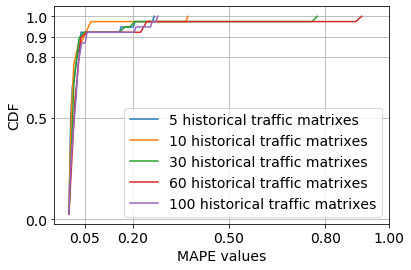

In [4]:
mape_lists = {}

# 将每个split_time的各项指标画成CDF图
for split_time in split_times:
    accurancy_records = accurancy_records_per_split[split_time]
    mape_lists[split_time] = [r['mape'] for r in accurancy_records]

# MAPE plots
map_plots = get_CDF_plot(mape_lists, "MAPE values", font_size=14)
map_plots.grid()
map_plots.legend(fontsize=14)
map_plots.savefig("images/MAPETrafficMatrixPrediction.pdf", dpi=800, format='pdf', bbox_inches = 'tight')
map_plots.show()
